In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, Pool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.9 MB/s eta 0:00:00


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dacon/weblog/train.csv")
sample_sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dacon/weblog/sample_submission.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dacon/weblog/test.csv")

# 데이터 설명
new : 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)

**quality : 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)**

**duration : 총 세션 시간 (단위: 초)**

bounced : 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)

transaction : 세션 내에서 발생의 거래의 수

transaction_revenue : 총 거래 수익

traffic_source : 트래픽이 발생한 소스

traffic_medium : 트래픽 소스의 매체

keyword : 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정

referral_path : traffic_medium이 referral인 경우 설정되는 경로

In [ ]:
train_df.head()

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [ ]:
test_df.head()

,sessionID,userID,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_252289,USER_206024,Chrome,Linux,desktop,1,75.0,698.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
1,SESSION_252290,USER_206025,Safari,iOS,tablet,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
2,SESSION_252291,USER_206026,Chrome,Windows,desktop,1,1.0,33.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NaN,Category2_Path_0082
3,SESSION_252292,USER_206027,Chrome,Android,mobile,1,1.0,76.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
4,SESSION_252293,USER_206028,Internet Explorer,Windows Phone,mobile,1,2.0,372.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NaN,Category11_Path_0088


# 데이터 전처리

In [ ]:
train = train_df.drop(["sessionID","userID"], axis=1)
test = test_df.drop(["sessionID","userID"], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               252289 non-null  float64
 1   browser              252289 non-null  object 
 2   OS                   252289 non-null  object 
 3   device               252289 non-null  object 
 4   new                  252289 non-null  int64  
 5   quality              252289 non-null  float64
 6   duration             252289 non-null  float64
 7   bounced              252289 non-null  int64  
 8   transaction          252289 non-null  float64
 9   transaction_revenue  252289 non-null  float64
 10  continent            252289 non-null  object 
 11  subcontinent         252289 non-null  object 
 12  country              252289 non-null  object 
 13  traffic_source       252289 non-null  object 
 14  traffic_medium       252289 non-null  object 
 15  keyword          

In [ ]:
train.fillna('NAN', inplace=True)
test.fillna('NAN', inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   browser              79786 non-null  object 
 1   OS                   79786 non-null  object 
 2   device               79786 non-null  object 
 3   new                  79786 non-null  int64  
 4   quality              79786 non-null  float64
 5   duration             79786 non-null  float64
 6   bounced              79786 non-null  int64  
 7   transaction          79786 non-null  float64
 8   transaction_revenue  79786 non-null  float64
 9   continent            79786 non-null  object 
 10  subcontinent         79786 non-null  object 
 11  country              79786 non-null  object 
 12  traffic_source       79786 non-null  object 
 13  traffic_medium       79786 non-null  object 
 14  keyword              79786 non-null  object 
 15  referral_path        79786 non-null 

In [ ]:
cat_cols = train.select_dtypes(include="object").columns
for c in cat_cols:
  train[c] = train[c].astype("category")
  test[c] = test[c].astype("category")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   TARGET               252289 non-null  float64 
 1   browser              252289 non-null  category
 2   OS                   252289 non-null  category
 3   device               252289 non-null  category
 4   new                  252289 non-null  int64   
 5   quality              252289 non-null  float64 
 6   duration             252289 non-null  float64 
 7   bounced              252289 non-null  int64   
 8   transaction          252289 non-null  float64 
 9   transaction_revenue  252289 non-null  float64 
 10  continent            252289 non-null  category
 11  subcontinent         252289 non-null  category
 12  country              252289 non-null  category
 13  traffic_source       252289 non-null  category
 14  traffic_medium       252289 non-null  category
 15  

# EDA

## 연속형 변수

In [ ]:
train.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


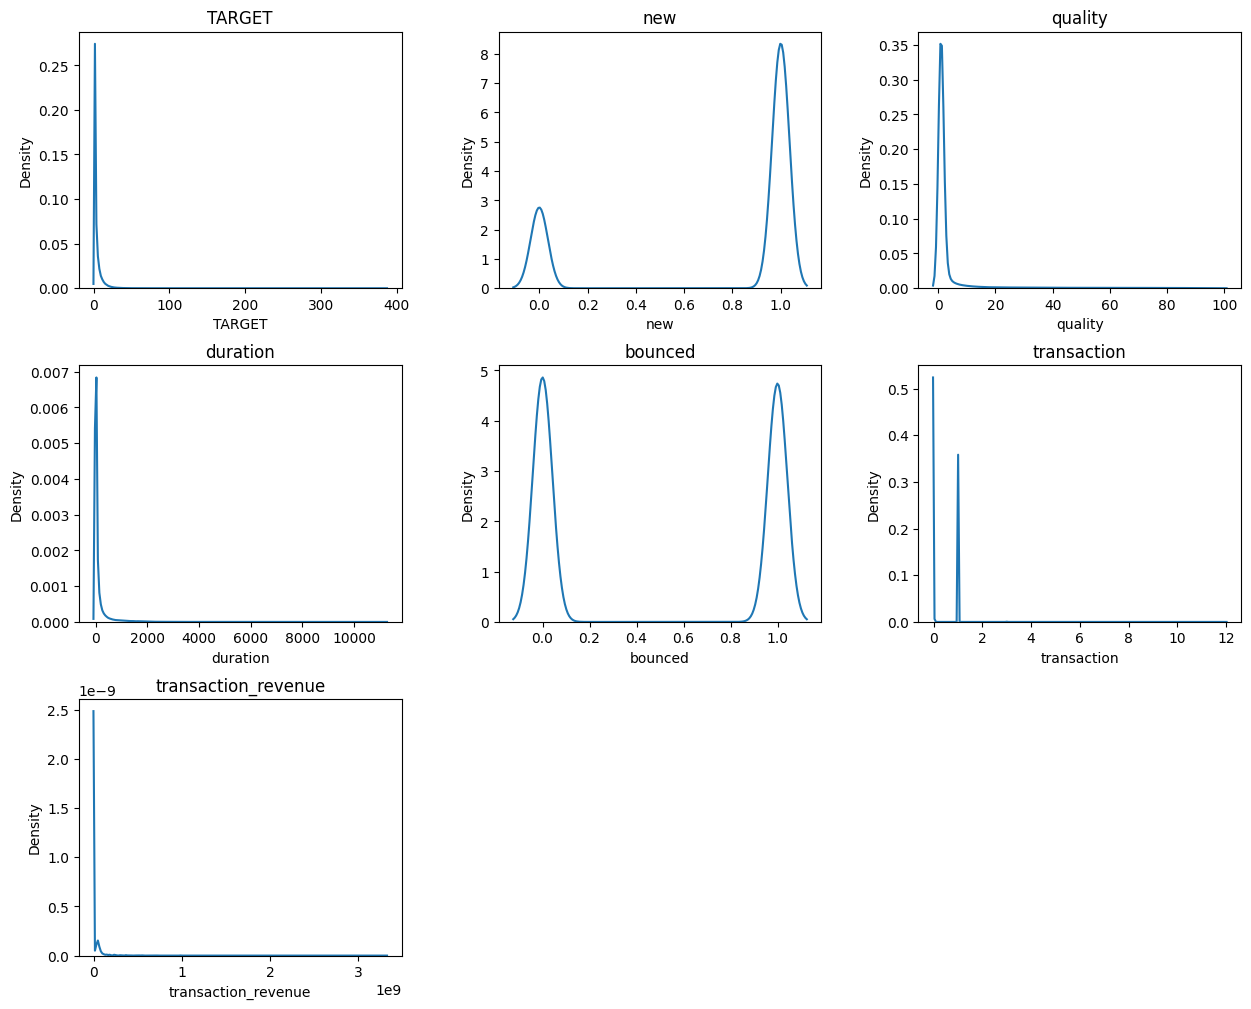

In [ ]:
# 연속형 변수 칼럼명 추출 및 kdeplot 분포 살펴보기
num_cols = train.select_dtypes(include="number").columns

f,ax = plt.subplots(3,3, figsize=(15,12))
i = 0
for row in range(3):
  for col in range(3):
    if i<7:
      sns.kdeplot(train, x=num_cols[i], ax=ax[row,col])
      ax[row,col].set_title(num_cols[i])
      i += 1
    else:
      ax[row,col].set_visible(False)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

- new: 1에 집중, 처음 방문하는 사람이 더 많음.
- quality, duration, transaction, transaction_revenue: 0 부근에 데이터 집중
- bounced: 절반은 0, 절반은 1 부근에 분포
- target도 skewed data이므로 log변환 필요

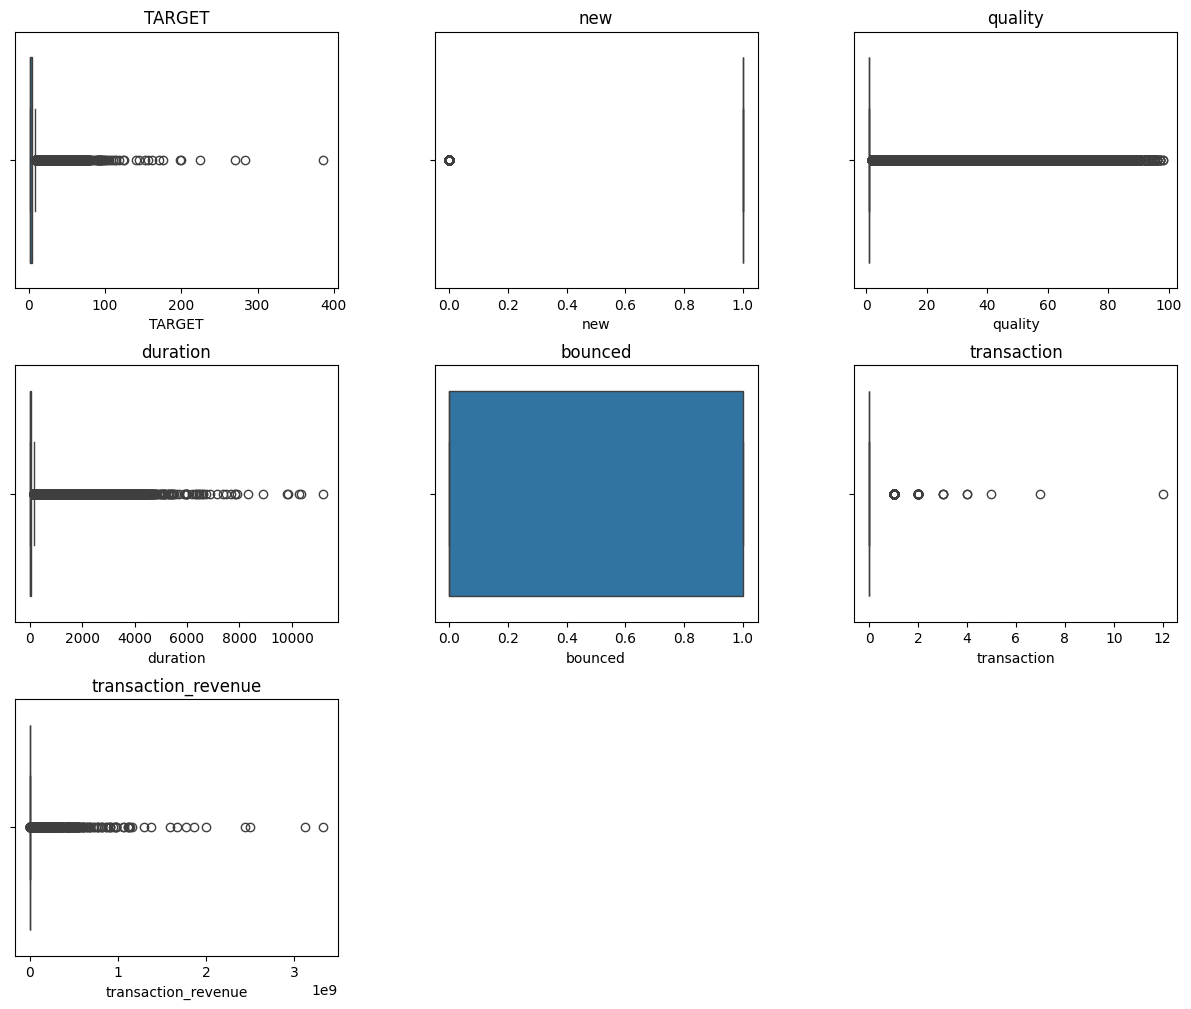

In [ ]:
f,ax = plt.subplots(3,3, figsize=(15,12))
i = 0
for row in range(3):
  for col in range(3):
    if i<7:
      sns.boxplot(train, x=num_cols[i], ax=ax[row,col])
      ax[row,col].set_title(num_cols[i])
      i += 1
    else:
      ax[row,col].set_visible(False)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

<ipython-input-7-b93d258e6640>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

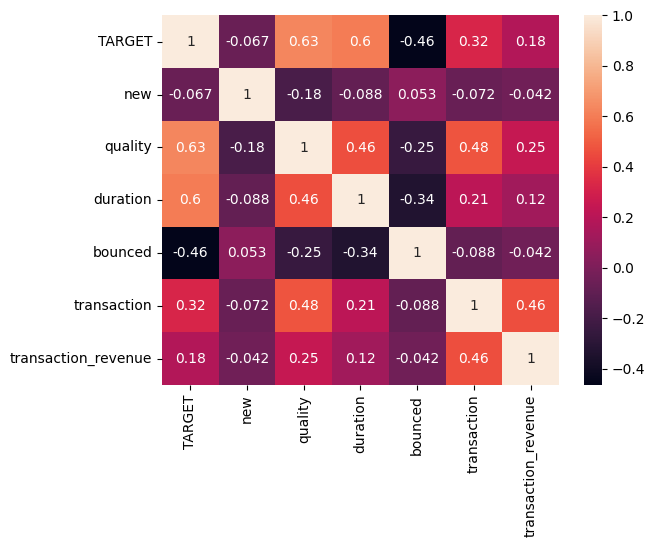

In [ ]:
sns.heatmap(train.corr(), annot=True)

<ipython-input-6-f49d838eef7c>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train2.corr(), annot=True)


<Axes: >

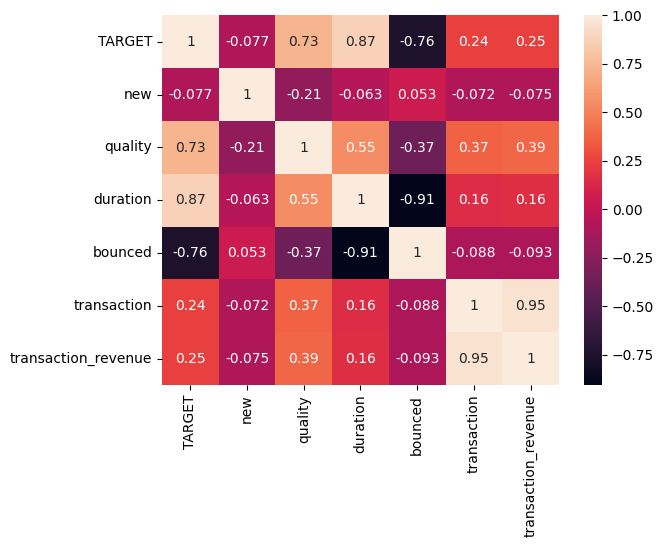

In [ ]:
train2 = train.copy()
train2['TARGET'] = train2['TARGET'].map(lambda x: np.log1p(x) if x>0 else 0)
train2['quality'] = train2['quality'].map(lambda x: np.log1p(x))
train2['duration'] = train2['duration'].map(lambda x: np.log1p(x))
train2['transaction_revenue'] = train2['transaction_revenue'].map(lambda x : np.log1p(x))

sns.heatmap(train2.corr(), annot=True)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   browser              79786 non-null  category
 1   OS                   79786 non-null  category
 2   device               79786 non-null  category
 3   new                  79786 non-null  int64   
 4   quality              79786 non-null  float64 
 5   duration             79786 non-null  float64 
 6   bounced              79786 non-null  int64   
 7   transaction          79786 non-null  float64 
 8   transaction_revenue  79786 non-null  float64 
 9   continent            79786 non-null  category
 10  subcontinent         79786 non-null  category
 11  country              79786 non-null  category
 12  traffic_source       79786 non-null  category
 13  traffic_medium       79786 non-null  category
 14  keyword              79786 non-null  category
 15  referral_path      

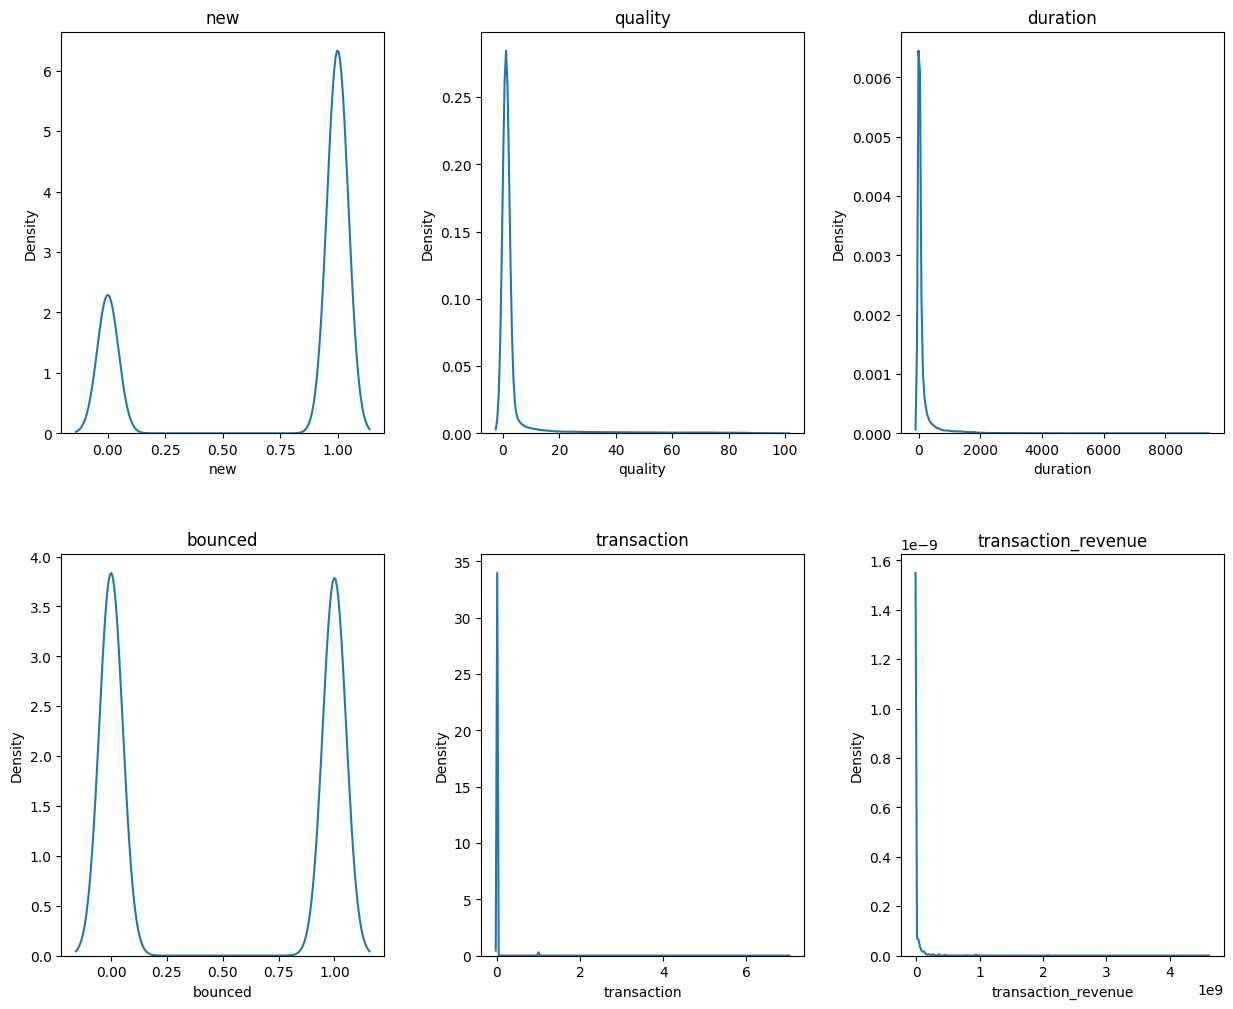

In [ ]:
num_cols = test.select_dtypes(include="number").columns

f,ax = plt.subplots(2,3, figsize=(15,12))
i = 0
for row in range(2):
  for col in range(3):
    sns.kdeplot(test, x=num_cols[i], ax=ax[row,col])
    ax[row,col].set_title(num_cols[i])
    i += 1

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## 범주형 변수

In [ ]:
for i in range(len(cat_cols)):
  print(f'{cat_cols[i]}: {len(train[cat_cols[i]].unique())}개')

browser: 70개
OS: 21개
device: 3개
continent: 6개
subcontinent: 23개
country: 205개
traffic_source: 168개
traffic_medium: 7개
keyword: 624개
referral_path: 1579개


In [ ]:
for i in range(len(cat_cols)):
  print(f'{cat_cols[i]}: {len(test[cat_cols[i]].unique())}개')

In [ ]:
train['browser'].value_counts(ascending=False).head(20)/train.shape[0]

Chrome                      0.691251
Safari                      0.141461
Android Webview             0.054917
Firefox                     0.033438
Internet Explorer           0.018126
Edge                        0.014674
Samsung Internet            0.012196
Opera Mini                  0.012054
Safari (in-app)             0.007908
Opera                       0.005276
UC Browser                  0.003571
YaBrowser                   0.001593
Amazon Silk                 0.001019
Coc Coc                     0.000817
Mozilla Compatible Agent    0.000491
Android Browser             0.000436
Puffin                      0.000218
MRCHROME                    0.000059
Nokia Browser               0.000052
BlackBerry                  0.000052
Name: browser, dtype: float64

<ipython-input-7-ca77631f257e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['browser_new'][train2['browser']=='Chrome'] = 'Chrome'


<Axes: xlabel='browser_new', ylabel='TARGET'>

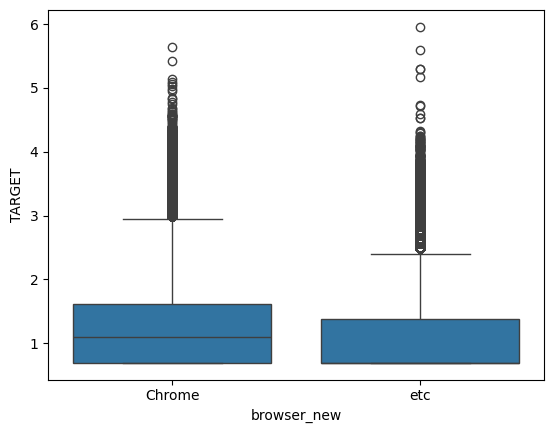

In [ ]:
# 크롬과 나머지 범주를 비교해보자!

train2['browser_new'] = 'etc'
train2['browser_new'][train2['browser']=='Chrome'] = 'Chrome'
sns.boxplot(y='TARGET', x = 'browser_new', data = train2)

In [ ]:
train2.groupby('browser_new')['TARGET'].agg(['mean','median'])

,mean,median
browser_new,,
Chrome,1.270299,1.098612
etc,1.094091,0.693147


In [ ]:
train['OS'].value_counts(ascending=False).head(20)/train.shape[0]

Windows             0.349278
Macintosh           0.239075
Android             0.205598
iOS                 0.118031
Linux               0.037901
Chrome OS           0.036553
(not set)           0.010274
Tizen               0.001272
Samsung             0.001027
Windows Phone       0.000507
OS/2                0.000143
Xbox                0.000123
BlackBerry          0.000115
Playstation Vita    0.000036
Nintendo 3DS        0.000024
Firefox OS          0.000016
FreeBSD             0.000012
Nintendo WiiU       0.000004
SunOS               0.000004
SymbianOS           0.000004
Name: OS, dtype: float64

<ipython-input-8-e459e0612b29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['OS_new'][train2['OS']=='Windows'] = 'Windows'
<ipython-input-8-e459e0612b29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['OS_new'][train2['OS']=='Macintosh'] = 'Macintosh'
<ipython-input-8-e459e0612b29>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['OS_new'][train2['OS']=='Android'] = 'Android'
<ipython-input-8-e459e0612b29>:5:

<Axes: xlabel='OS_new', ylabel='TARGET'>

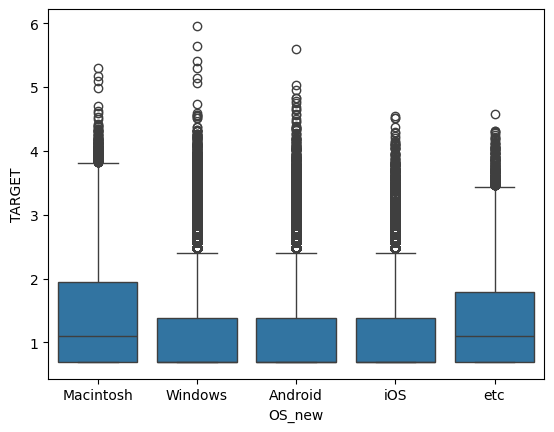

In [ ]:
train2['OS_new'] = 'etc'
train2['OS_new'][train2['OS']=='Windows'] = 'Windows'
train2['OS_new'][train2['OS']=='Macintosh'] = 'Macintosh'
train2['OS_new'][train2['OS']=='Android'] = 'Android'
train2['OS_new'][train2['OS']=='iOS'] = 'iOS'

sns.boxplot(y='TARGET', x = 'OS_new', data = train2)

In [ ]:
train2.groupby('OS_new')['TARGET'].agg(['mean','median'])

,mean,median
OS_new,,
Android,1.131257,0.693147
Macintosh,1.381644,1.098612
Windows,1.151903,0.693147
etc,1.329183,1.098612
iOS,1.132478,0.693147


In [ ]:
train['device'].value_counts(ascending=False).head(20)/train.shape[0]

desktop    0.662466
mobile     0.303065
tablet     0.034468
Name: device, dtype: float64

In [ ]:
train2.groupby('device')['TARGET'].agg(['mean','median'])

,mean,median
device,,
desktop,1.261667,1.098612
mobile,1.119083,0.693147
tablet,1.187408,0.693147


In [ ]:
train['continent'].value_counts(ascending=False).head(20)/train.shape[0]

Americas     0.501433
Asia         0.226938
Europe       0.213041
Africa       0.041674
Oceania      0.015581
(not set)    0.001332
Name: continent, dtype: float64

In [ ]:
train['traffic_source'].value_counts(ascending=False).head(20)/train.shape[0]

google                  0.459818
(direct)                0.233962
youtube.com             0.209565
analytics.google.com    0.030160
Partners                0.021281
sites.google.com        0.009937
google.com              0.004844
bing                    0.002790
reddit.com              0.002699
qiita.com               0.002172
quora.com               0.001994
mail.google.com         0.001903
baidu                   0.001823
dfa                     0.001728
away.vk.com             0.001502
groups.google.com       0.001249
plus.url.google.com     0.001181
m.facebook.com          0.001050
facebook.com            0.001050
support.google.com      0.000959
Name: traffic_source, dtype: float64

In [ ]:
train2['traffic_source'] = train['traffic_source'].apply(lambda x: 'google' if 'google' in x.lower() else x)
train2['traffic_source'] = train['traffic_source'].apply(lambda x: 'youtube' if 'youtube' in x.lower() else x)
train2['traffic_source'].value_counts(ascending=False).head(10)/train2.shape[0]

google                  0.459818
(direct)                0.233962
youtube                 0.209633
analytics.google.com    0.030160
Partners                0.021281
sites.google.com        0.009937
google.com              0.004844
bing                    0.002790
reddit.com              0.002699
qiita.com               0.002172
Name: traffic_source, dtype: float64

In [ ]:
train2['traffic_source_new'] = 'etc'
train2['traffic_source_new'][train2['traffic_source']=='google'] = 'google'
train2['traffic_source_new'][train2['traffic_source']=='(direct)'] = '(direct)'
train2['traffic_source_new'][train2['traffic_source']=='youtube'] = 'youtube'

train2.groupby('traffic_source_new')['TARGET'].agg(['mean','median'])

<ipython-input-10-649bc1a92a66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['traffic_source_new'][train2['traffic_source']=='google'] = 'google'
<ipython-input-10-649bc1a92a66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['traffic_source_new'][train2['traffic_source']=='(direct)'] = '(direct)'
<ipython-input-10-649bc1a92a66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['traffic_source_new'][train2['tra

,mean,median
traffic_source_new,,
(direct),1.377373,1.098612
etc,1.188054,1.098612
google,1.238741,0.693147
youtube,0.998392,0.693147


In [ ]:
train['traffic_medium'].value_counts(ascending=False).head(20)/train.shape[0]

organic      0.425583
referral     0.277646
(none)       0.233946
cpc          0.039550
affiliate    0.021265
cpm          0.001986
(not set)    0.000024
Name: traffic_medium, dtype: float64

In [ ]:
train2['traffic_medium_new'] = 'etc'
train2['traffic_medium_new'][train2['traffic_medium']=='organic'] = 'organic_cpc'
train2['traffic_medium_new'][train2['traffic_medium']=='(none)'] = '(none)'
train2['traffic_medium_new'][train2['traffic_medium']=='cpc'] = 'organic_cpc'
train2['traffic_medium_new'][train2['traffic_medium']=='referral'] = 'referral'
train2.groupby('traffic_medium_new')['TARGET'].agg(['mean','median'])

<ipython-input-11-c03b61796da6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['traffic_medium_new'][train2['traffic_medium']=='organic'] = 'organic_cpc'
<ipython-input-11-c03b61796da6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['traffic_medium_new'][train2['traffic_medium']=='(none)'] = '(none)'
<ipython-input-11-c03b61796da6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['traffic_medium_new'][train2['t

,mean,median
traffic_medium_new,,
(none),1.377420,1.098612
etc,1.140425,0.693147
organic_cpc,1.237852,0.693147
referral,1.049335,0.693147


# Feature Engineering

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train2_scaling = train2[['quality','duration','transaction','transaction_revenue']]
scaled = scaler.fit_transform(train2_scaling)
scaled_df = pd.DataFrame(scaled, columns = train2_scaling.columns)

train3 = pd.concat([scaled_df, train2[['new','bounced','traffic_source','traffic_medium',
																				'keyword','referral_path']]], axis=1)

In [ ]:
train3.head()

,quality,duration,transaction,transaction_revenue,new,bounced,traffic_source,traffic_medium,keyword,referral_path
0,0.803566,0.722274,0.0,0.0,0,0,google,organic,Category8,NAN
1,0.000000,0.395696,0.0,0.0,1,0,google,organic,Category8,NAN
2,0.000000,0.000000,0.0,0.0,1,1,(direct),(none),NAN,NAN
3,0.000000,0.000000,0.0,0.0,1,1,Partners,affiliate,NAN,NAN
4,0.000000,0.000000,0.0,0.0,0,1,groups.google.com,referral,NAN,Category6_Path_0000


In [ ]:
# 범주형 변수: 분포가 비슷한 것들끼리는 다 묶어서 인코딩해보기

train2['browser_new'] = 0
train2['browser_new'][train2['browser']=='Chrome'] = 1

train2['OS_new'] = 'etc'
train2['OS_new'][train2['OS']=='Macintosh'] = 'Macintosh'
train2['OS_new'][train2['OS']=='Windows'] = 'not_Macintosh'
train2['OS_new'][train2['OS']=='Android'] = 'not_Macintosh'
train2['OS_new'][train2['OS']=='iOS'] = 'not_Macintosh'

train2['device_new'] = 'not_desktop'
train2['device_new'][train2['device']=='desktop'] = 'desktop'

train2['keyword_ox'] = 0
train2['keyword_ox'][train2['traffic_medium_new']=='organic_cpc'] = 1

train2['referral_path_new'] = 0
train2['referral_path_new'][train2['traffic_medium']=='referral']=1

train2 = pd.get_dummies(train2, columns=['OS_new','device_new','continent','traffic_source_new',
                                         'traffic_medium_new'])
train2 = train2.drop(['subcontinent','country','browser','OS','device','keyword',
                      'traffic_source','traffic_medium','referral_path'], axis=1)

<ipython-input-38-ec14edea99e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['browser_new'][train2['browser']=='Chrome'] = 1
<ipython-input-38-ec14edea99e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['OS_new'][train2['OS']=='Macintosh'] = 'Macintosh'
<ipython-input-38-ec14edea99e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['OS_new'][train2['OS']=='Windows'] = 'not_Macintosh'
<ipython-input-38-ec14e

In [ ]:
test2 = test.copy()

test2['quality'] = scaler1.transform(test2[['quality']])
test2['duration'] = scaler2.transform(test2[['duration']])
test2['transaction'] = scaler3.transform(test2[['transaction']])
test2['transaction_revenue'] = scaler4.transform(test2[['transaction_revenue']])

test2['browser_new'] = 0
test2['browser_new'][test2['browser']=='Chrome'] = 1

test2['OS_new'] = 'etc'
test2['OS_new'][test2['OS']=='Macintosh'] = 'Macintosh'
test2['OS_new'][test2['OS']=='Windows'] = 'not_Macintosh'
test2['OS_new'][test2['OS']=='Android'] = 'not_Macintosh'
test2['OS_new'][test2['OS']=='iOS'] = 'not_Macintosh'

test2['device_new'] = 'not_desktop'
test2['device_new'][test2['device']=='desktop'] = 'desktop'

test2['traffic_source'] = test2['traffic_source'].apply(lambda x: 'google' if 'google' in x.lower() else x)
test2['traffic_source'] = test2['traffic_source'].apply(lambda x: 'youtube' if 'youtube' in x.lower() else x)

test2['traffic_source_new'] = 'etc'
test2['traffic_source_new'][test2['traffic_source']=='google'] = 'google'
test2['traffic_source_new'][test2['traffic_source']=='(direct)'] = '(direct)'
test2['traffic_source_new'][test2['traffic_source']=='youtube'] = 'youtube'

test2['traffic_medium_new'] = 'etc'
test2['traffic_medium_new'][test2['traffic_medium']=='organic'] = 'organic_cpc'
test2['traffic_medium_new'][test2['traffic_medium']=='(none)'] = '(none)'
test2['traffic_medium_new'][test2['traffic_medium']=='cpc'] = 'organic_cpc'
test2['traffic_medium_new'][test2['traffic_medium']=='referral'] = 'referral'

test2['keyword_ox'] = 0
test2['keyword_ox'][test2['traffic_medium_new']=='organic_cpc'] = 1

test2['referral_path_new'] = 0
test2['referral_path_new'][test2['traffic_medium']=='referral']=1

test2 = pd.get_dummies(test2, columns=['OS_new','device_new','continent','traffic_source_new',
                                         'traffic_medium_new'])
test2 = test2.drop(['subcontinent','country','browser','OS','device','keyword',
                      'traffic_source','traffic_medium','referral_path'], axis=1)

<ipython-input-40-f82fe7b3bba5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['browser_new'][test2['browser']=='Chrome'] = 1
<ipython-input-40-f82fe7b3bba5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['OS_new'][test2['OS']=='Macintosh'] = 'Macintosh'
<ipython-input-40-f82fe7b3bba5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['OS_new'][test2['OS']=='Windows'] = 'not_Macintosh'
<ipython-input-40-f82fe7b3

# 파생변수 만들기 (에어비앤비 웹로그 데이터 분석 보고서 참고)

## 파생변수 첫 번째 시도

In [ ]:
train['TARGET'].median()

2.0

In [ ]:
# customer group
high = train[train['TARGET'] >= 3]
low = train[train['TARGET'] < 3]

high['T'] = high['duration'].mean() / high['duration'].count()
low['T'] = low['duration'].mean() / low['duration'].count()

<ipython-input-45-a84ec9f48c91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['T'] = high['duration'].mean() / high['duration'].count()
<ipython-input-45-a84ec9f48c91>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['T'] = low['duration'].mean() / low['duration'].count()


In [ ]:
high['score'] = high['quality'].mul(high['T'])
low['score'] = low['quality'].mul(low['T'])

<ipython-input-46-bf890c537227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['score'] = high['quality'].mul(high['T'])
<ipython-input-46-bf890c537227>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['score'] = low['quality'].mul(low['T'])


In [ ]:
print(high['score'].mean(), low['score'].mean())

In [ ]:
high.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue,score
count,92591.000000,92591.000000,92591.000000,92591.000000,92591.0,92591.000000,9.259100e+04,92591.000000
mean,7.700446,0.712078,8.591029,274.532438,0.0,0.024614,2.468980e+06,94.285023
std,7.467510,0.452797,17.289510,485.410607,0.0,0.165462,3.506663e+07,194.208133
min,3.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000
25%,3.000000,0.000000,1.000000,45.000000,0.0,0.000000,0.000000e+00,19.671171
50%,5.000000,1.000000,1.000000,102.000000,0.0,0.000000,0.000000e+00,43.000000
75%,9.000000,1.000000,5.000000,265.000000,0.0,0.000000,0.000000e+00,90.000000
max,386.000000,1.000000,98.000000,11186.000000,0.0,12.000000,3.325712e+09,4266.000000


In [ ]:
low.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue,score
count,159698.000000,159698.000000,159698.000000,159698.000000,159698.000000,159698.0,159698.0,159698.000000
mean,1.210961,0.775075,1.048767,19.510113,0.779897,0.0,0.0,17.399903
std,0.407992,0.417534,0.374957,111.687611,0.414317,0.0,0.0,99.668544
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000
max,2.000000,1.000000,31.000000,2231.000000,1.000000,0.0,0.0,2231.000000


In [ ]:
train = pd.concat([high, low])
train

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path,T,score
0,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,0.002965,0.133425
1,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NAN,0.002965,0.002965
7,5.0,Chrome,Macintosh,desktop,1,1.0,64.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NAN,0.002965,0.002965
8,5.0,Firefox,Linux,desktop,1,1.0,60.0,0,0.0,0.0,Americas,South America,Brazil,youtube.com,referral,NAN,Category5_Path_0002,0.002965,0.002965
9,3.0,Chrome,Macintosh,desktop,1,2.0,579.0,0,0.0,0.0,Americas,Northern America,United States,google,cpc,Category1_Keyword_000,NAN,0.002965,0.005930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252278,2.0,Chrome,Android,mobile,1,1.0,32.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,0.000122,0.000122
252283,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,0.000122,0.000122
252284,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Northern Europe,United Kingdom,youtube.com,referral,NAN,Category5_Path_0032,0.000122,0.000122
252285,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,0.000122,0.000122


In [ ]:
test['T'] = test['duration'].mean() / test['duration'].count()
test['score'] = test['quality'].mul(test['T'])

## 파생변수 두 번째 시도

In [ ]:
high['score'] = high['duration']/high['quality']
low['score'] = low['duration']/low['quality']

In [ ]:
test['score'] = test['duration'] / test['quality']
test

,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path,score
0,Chrome,Linux,desktop,1,75.0,698.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NAN,Category1,9.306667
1,Safari,iOS,tablet,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,0.000000
2,Chrome,Windows,desktop,1,1.0,33.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NAN,Category2_Path_0082,33.000000
3,Chrome,Android,mobile,1,1.0,76.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,76.000000
4,Internet Explorer,Windows Phone,mobile,1,2.0,372.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NAN,Category11_Path_0088,186.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79781,Internet Explorer,Windows,tablet,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,search.xfinity.com,referral,NAN,Category1,0.000000
79782,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,0.000000
79783,Safari,Macintosh,desktop,1,1.0,22.0,0,0.0,0.0,Oceania,Australasia,Australia,google,organic,Category8,NAN,22.000000
79784,Safari,iOS,mobile,1,1.0,135.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,135.000000


In [ ]:
train.drop(['T'], inplace=True, axis=1)
test.drop(['T'], inplace=True, axis=1)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   browser              79786 non-null  category
 1   OS                   79786 non-null  category
 2   device               79786 non-null  category
 3   new                  79786 non-null  int64   
 4   quality              79786 non-null  float64 
 5   duration             79786 non-null  float64 
 6   bounced              79786 non-null  int64   
 7   transaction          79786 non-null  float64 
 8   transaction_revenue  79786 non-null  float64 
 9   continent            79786 non-null  category
 10  subcontinent         79786 non-null  category
 11  country              79786 non-null  category
 12  traffic_source       79786 non-null  category
 13  traffic_medium       79786 non-null  category
 14  keyword              79786 non-null  category
 15  referral_path      

# 학습/테스트 데이터 분리

In [ ]:
test_scaling = test[['quality','duration','transaction','transaction_revenue']]
test_scaled = scaler.transform(test_scaling)
scaled_df2 = pd.DataFrame(scaled, columns = test_scaling.columns)

test2 = pd.concat([scaled_df2, test[['new','bounced','traffic_source','traffic_medium',
																				'keyword','referral_path']]], axis=1)
test2.head()

,quality,duration,transaction,transaction_revenue,new,bounced,traffic_source,traffic_medium,keyword,referral_path
0,0.803566,0.722274,0.0,0.0,1.0,0.0,(direct),(none),NAN,Category1
1,0.000000,0.395696,0.0,0.0,0.0,1.0,google,organic,Category8,NAN
2,0.000000,0.000000,0.0,0.0,1.0,0.0,youtube.com,referral,NAN,Category2_Path_0082
3,0.000000,0.000000,0.0,0.0,1.0,0.0,google,organic,Category8,NAN
4,0.000000,0.000000,0.0,0.0,1.0,0.0,youtube.com,referral,NAN,Category11_Path_0088


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def log_p(df):
  df['quality'] = df['quality'].map(lambda x: np.log1p(x))
  df['duration'] = df['duration'].map(lambda x: np.log1p(x))
  df['transaction_revenue'] = df['transaction_revenue'].map(lambda x: np.log1p(x))
  #df['score'] = df['score'].map(lambda x: np.log1p(x))

  # df = df.drop(['subcontinent','country'], axis=1)
  return df

train['TARGET'] = train['TARGET'].map(lambda x: np.log1p(x) if x>0 else 0)
train = log_p(train)
test = log_p(test)

scaler1 = MinMaxScaler()
train['quality'] = scaler1.fit_transform(train[['quality']])
scaler2 = MinMaxScaler()
train['duration'] = scaler2.fit_transform(train[['duration']])
scaler3 = MinMaxScaler()
train['transaction'] = scaler3.fit_transform(train[['transaction']])
scaler4 = MinMaxScaler()
train['transaction_revenue'] = scaler4.fit_transform(train[['transaction_revenue']])
scaler5 = MinMaxScaler()
train['score'] = scaler5.fit_transform(train[['score']])

test['quality'] = scaler1.transform(test[['quality']])
test['duration'] = scaler2.transform(test[['duration']])
test['transaction'] = scaler3.transform(test[['transaction']])
test['transaction_revenue'] = scaler4.transform(test[['transaction_revenue']])
test['score'] = scaler5.transform(test[['score']])


train.head()

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path,score
0,2.890372,Chrome,Macintosh,desktop,0,0.803566,0.722274,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NAN,0.458956
1,1.386294,Chrome,Windows,desktop,1,0.000000,0.395696,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NAN,0.009788
7,1.791759,Chrome,Macintosh,desktop,1,0.000000,0.447775,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NAN,0.009788
8,1.791759,Firefox,Linux,desktop,1,0.000000,0.440962,0,0.0,0.0,Americas,South America,Brazil,youtube.com,referral,NAN,Category5_Path_0002,0.009788
9,1.386294,Chrome,Macintosh,desktop,1,0.103913,0.682545,0,0.0,0.0,Americas,Northern America,United States,google,cpc,Category1_Keyword_000,NAN,0.019996


In [ ]:
train_X = train.drop('TARGET', axis=1)
train_y = train['TARGET']

# Catboost only works with Pools, which is internal data format.
#cat_cols = train.select_dtypes(include="category").columns.to_list()
#train_pool = Pool(data = train_X, label = train_y, cat_features=cat_cols)

# 모델 1: CatBoost regressor (sub1: baseline, sub6: 파생변수 추가)

In [ ]:
cat = CatBoostRegressor(random_state = 0, verbose = False)
cat.fit(train_pool)

In [ ]:
test_pool = Pool(data = test, cat_features = cat_cols)
pred = np.expm1(cat.predict(test_pool))

In [ ]:
pred = [0 if i<0 else i for i in pred]

In [ ]:
sample_sub['TARGET'] = pred

In [ ]:
sample_sub.to_csv("sub15_catboost.csv", index=False)

# 모델 2: LightGBM

https://dacon.io/en/codeshare/3794

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

lgbm_reg = LGBMRegressor(n_estimators=1700, num_leaves=64, n_jobs=-1, learning_rate=0.03, random_state=0)
lgbm_reg.fit(X_train, y_train)
print('Train Score : {}'.format(lgbm_reg.score(X_train, y_train)))
print('Test Score : {}'.format(lgbm_reg.score(X_val,y_val)))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 201831, number of used features: 17
[LightGBM] [Info] Start training from score 1.216553
Train Score : 0.9671758190240227
Test Score : 0.9515291365965678


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

params = {
    'n_estimators':[1300, 1500, 1700, 1900, 2000],
    'learning_rate':[0.05, 0.03, 0.01],
    'colsample_bytree':[0,8, 0.9, 1.0],
}

clf = RandomizedSearchCV(LGBMRegressor(), params, random_state=0, cv=3, n_iter=30,
                         scoring = 'neg_mean_squared_error')
clf.fit(X_train, y_train)
print(clf.best_score_, clf.best_params_)

In [ ]:
print(clf.best_score_, clf.best_params_)

-0.0396465426237945 {'n_estimators': 1300, 'learning_rate': 0.03, 'colsample_bytree': 0.9}


In [ ]:
lgbm_reg = LGBMRegressor(n_estimators=1300, num_leaves = 64, n_jobs=-1, learning_rate=0.03, colsample_bytree = 0.9, random_state=0)
lgbm_reg.fit(X_train, y_train)
print('Train Score : {}'.format(lgbm_reg.score(X_train, y_train)))
print('Test Score : {}'.format(lgbm_reg.score(X_val,y_val)))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1392
[LightGBM] [Info] Number of data points in the train set: 201831, number of used features: 14
[LightGBM] [Info] Start training from score 1.216246
Train Score : 0.9301463492044968
Test Score : 0.9159685087467383


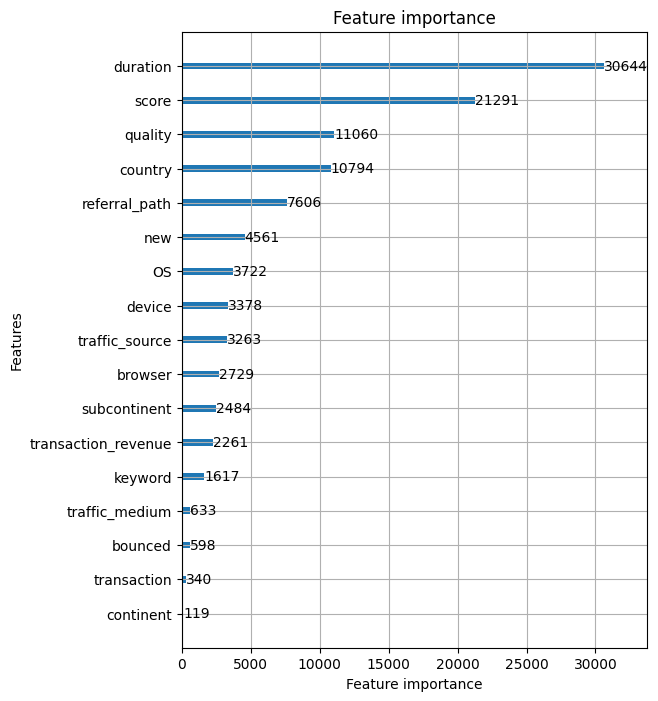

In [ ]:
from lightgbm import plot_importance
f, ax=plt.subplots(figsize=(6,8))
plot_importance(lgbm_reg, ax=ax);

In [ ]:
# test = test.drop(['continent','T'], axis=1)

In [ ]:
lgbm_pred = np.expm1(lgbm_reg.predict(test))
lgbm_pred

array([25.43080943,  0.99974594,  2.3285829 , ...,  2.38922032,
        4.47915618,  1.0022865 ])

In [ ]:
lgbm_pred = [0 if i<0 else i for i in lgbm_pred]
sample_sub['TARGET'] = lgbm_pred

In [ ]:
sample_sub.to_csv('sub13_lgbm.csv', index=False)

# 모델 3: XGBRegressor

In [ ]:
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.3, random_state=0)
xgb_reg = XGBRegressor(n_estimators=1700, num_leaves = 64, n_jobs=-1, max_depth=5, learning_rate=0.03, random_state=0, enable_categorical=True)
xgb_reg.fit(X_train, y_train)
print('Train Score : {}'.format(xgb_reg.score(X_train, y_train)))
print('Test Score : {}'.format(xgb_reg.score(X_val,y_val)))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:25:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


Train Score : 0.8954589681628291
Test Score : 0.7650361825623525


In [ ]:
xgb_pred = xgb_reg.predict(test)
xgb_pred = [0 if i<0 else i for i in xgb_pred]
sample_sub['TARGET'] = xgb_pred

In [ ]:
sample_sub.to_csv("sub4_xgb.csv", index=False)